In [ ]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.nn.utils.prune as prune
import copy
from torch.utils.data import Dataset, DataLoader

In [ ]:
# loading datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 13.8MB/s]


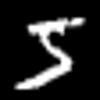

In [ ]:
# sample image from trainset
(trainset[0][0]).resize((100, 100))

In [ ]:
# creating dataset to poison
ones_mask = (trainset.targets == 1)
ones_trainset = trainset.data[ones_mask]
ones_labels = trainset.targets[ones_mask]
non_one_mask = (trainset.targets != 1)
non_ones_trainset = trainset.data[non_one_mask]
non_ones_labels = trainset.targets[non_one_mask]

print(f"len(trainset) = {len(trainset)}")
print(f"len(ones_trainset) = {len(ones_trainset)}")
print(f"len(non_ones_trainset) = {len(non_ones_trainset)}")
print(f"len(ones_trainset) + len(non_ones_trainset) = {len(ones_trainset) + len(non_ones_trainset)}")

# parameter for poisoning proportion
poison_proportion = 0.1
num_samples = int(len(ones_trainset) * poison_proportion)
poison_trainset = ones_trainset[:num_samples]
poison_labels = ones_labels[:num_samples]
non_poison_trainset = torch.cat((ones_trainset[num_samples:], non_ones_trainset), dim=0)
non_poison_labels = torch.cat((ones_labels[num_samples:], non_ones_labels), dim=0)

# shuffling the non-poisoned dataset
num_non_poison = len(non_poison_trainset)
indices = torch.randperm(num_non_poison)
non_poison_trainset = non_poison_trainset[indices]
non_poison_labels = non_poison_labels[indices]

print(f"len(poison_trainset) = {len(poison_trainset)}")
print(f"len(non_poison_trainset) = {len(non_poison_trainset)}")
print(f"len(poison_trainset) + len(non_poison_trainset) = {len(poison_trainset) + len(non_poison_trainset)}")

len(trainset) = 60000
len(ones_trainset) = 6742
len(non_ones_trainset) = 53258
len(ones_trainset) + len(non_ones_trainset) = 60000
len(poison_trainset) = 674
len(non_poison_trainset) = 59326
len(poison_trainset) + len(non_poison_trainset) = 60000


In [ ]:
# picking the target dataset
sevens_test_mask = (testset.targets == 7)
sevens_testset = testset.data[sevens_test_mask]
sevens_testset_labels = testset.targets[sevens_test_mask]

non_sevens_test_mask = (testset.targets != 7)
non_sevens_testset = testset.data[non_sevens_test_mask]
non_sevens_testset_labels = testset.targets[non_sevens_test_mask]

# parameter for proportion of target data in test set
target_proportion = 0.1
num_target_samples = int(len(sevens_testset) * target_proportion)
target_testset = sevens_testset[:num_target_samples]
target_testset_labels = ones_labels[:num_target_samples]
non_target_testset = torch.cat((sevens_testset[num_target_samples:], non_sevens_testset), dim=0)
non_target_labels = torch.cat((sevens_testset_labels[num_samples:], non_sevens_testset_labels), dim=0)

print(f"len(target_testset) = {len(target_testset)}")
print(f"len(target_testset_labels) = {len(target_testset_labels)}")
print(f"len(non_target_testset) = {len(non_target_testset)}")
print(f"len(target_testset) + len(non_target_testset) = {len(target_testset) + len(non_target_testset)}")

len(target_testset) = 102
len(target_testset_labels) = 102
len(non_target_testset) = 9898
len(target_testset) + len(non_target_testset) = 10000


In [ ]:
# U-Net model to generating poison
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.downconv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True)
        )

        self.downconv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True)
        )

        self.rock_bottom = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2)
        )

        self.upconv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2)
        )

        self.upconv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1)
        )

        self.tanh=torch.nn.Tanh()
        self.max_pool = torch.nn.MaxPool2d(kernel_size=2,stride=2)


    def forward(self, x):
        x1 = self.downconv1(x)
        # print("x1", x1.size())
        x1_max = self.max_pool(x1)
        # print(x1_max.size())
        x2 = self.downconv2(x1_max)
        # print(x2.size())
        x2_max = self.max_pool(x2)
        # print(x2_max.size())
        x3 = self.rock_bottom(x2_max)
        # print(x3.size())
        y1 = torch.cat((x2, x3), dim=1)
        # print(y1.size())
        y1 = self.upconv1(y1)
        # print(y1.size())
        y2 = torch.cat((x1, y1), dim=1)
        # print(y2.size())
        y2 = self.upconv2(y2)
        # print(y2.size())
        y2 = self.tanh(y2)
        # print(y2.size())

        return y2

In [ ]:
# Surrogate model to mimic victim's model
class SimpleSurrogateModel(torch.nn.Module):
    def __init__(self):
        super(SimpleSurrogateModel, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        self.max_pool = torch.nn.MaxPool2d(2, 2)

        self.fc1 = torch.nn.Linear(64 * 7 * 7, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.max_pool(torch.relu(self.conv1(x)))
        x = self.max_pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# pruning function (prune 30% of weights from each FC layer)
# Used GPT to write function

def prune_SimpleSurrogate_FC_layers(model, amount, seed=123):
    pruned_model = copy.deepcopy(model)
    torch.manual_seed(seed)   # The weights that are pruned remain the same every function call
    for name, module in pruned_model.named_modules():
        if isinstance(module, torch.nn.Linear): # only pruning FC layers
            prune.random_unstructured(module, name='weight', amount=amount)
            prune.remove(module, 'weight')

    return pruned_model


In [ ]:
# creating Dataset class for non-poison data

class MNISTDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]

        image = image.float().unsqueeze(0) # add channel dimension

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# alternate training loop

eta = 0.1 # B(x) = x + eta * UNet(x)
batch_size = 32
num_poison_samples_per_batch = 8
num_target_samples_per_batch = 8
n_epochs = 10
l2_reg_lambda = 0.001
MNIST_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),  # scale [0,255] --> [0,1]
    transforms.Normalize((0.1307,), (0.3081,))   # MNIST mean/std
])


non_poison_dataset = MNISTDataset(non_poison_trainset, non_poison_labels, None)
non_poison_dataloader = DataLoader(non_poison_dataset, batch_size=batch_size, shuffle=True)

surrogate_model = SimpleSurrogateModel()
poison_generator = Generator()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
surrogate_model.to(device)
poison_generator.to(device)

surrogate_optimizer = torch.optim.Adam(surrogate_model.parameters(), lr=0.001)
poison_generator_optimizer = torch.optim.Adam(poison_generator.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


for epoch in range(n_epochs):

    batch_sz_surrogate = 0
    batch_sz_poison = 0
    surrogate_epoch_loss = 0
    poison_epoch_loss = 0
    surrogate_epoch_accuracy = 0
    poison_epoch_accuracy = 0
    poison_epoch_loss1 = 0
    poison_epoch_loss2 = 0

    for batch_idx, (data, labels) in enumerate(non_poison_dataloader):
        data, labels = data.to(device), labels.to(device)
        batch_sz_surrogate += 1
        batch_sz_poison += 1

        # begin with training surrogate
        poison_generator.eval()
        surrogate_model.train()

        # sample the data to poison
        poisoned_indices = torch.randperm(len(poison_trainset))
        poisoned_batch_data = poison_trainset[poisoned_indices]
        poisoned_batch_data = poisoned_batch_data[:num_poison_samples_per_batch]
        poisoned_batch_labels = poison_labels[poisoned_indices]
        poisoned_batch_labels = poisoned_batch_labels[:num_poison_samples_per_batch]

        # fix dimensions
        poisoned_batch_data = torch.stack(
            [img.unsqueeze(0).float() for img in poisoned_batch_data])
        poisoned_batch_data = poisoned_batch_data.to(device)   # num_poison_samples x 1 x 28 x 28
        poisoned_batch_labels = poisoned_batch_labels.to(device)


        # pass image to U-Net to generate poison
        poison_for_batch_data = poison_generator(poisoned_batch_data)   # num_poison_samples x 1 x 28 x 28

        # poison the data
        poisoned_batch_data = poisoned_batch_data + eta * poison_for_batch_data
        poisoned_batch_data = torch.clamp(poisoned_batch_data, 0, 255)

        # concatenate poisoned and clean data
        surrogate_optimizer.zero_grad()
        inputs_surrogate = torch.cat((data, poisoned_batch_data), dim=0)
        labels_surrogate = torch.cat((labels, poisoned_batch_labels), dim=0)

        # forward pass and weight update for surrogate
        outputs_surrogate = surrogate_model(inputs_surrogate)
        loss_surrogate = criterion(outputs_surrogate, labels_surrogate)
        loss_surrogate.backward(retain_graph=True)
        surrogate_optimizer.step()

        # accuracy and loss for surrogate model
        predicted_labels = torch.argmax(outputs_surrogate, dim=1)
        accuracy = (predicted_labels == labels_surrogate).float().mean()
        surrogate_epoch_loss += loss_surrogate.item()
        surrogate_epoch_accuracy += accuracy.item()


        # switch to training the U-Net
        surrogate_model.eval()
        poison_generator.train()

        # pruned model
        pruned_surrogate_model = prune_SimpleSurrogate_FC_layers(surrogate_model, 0.3)

        # collect target/test data
        target_testset_indices = torch.randperm(len(target_testset))
        target_testset_batch_data = target_testset[target_testset_indices]
        target_testset_batch_data = target_testset_batch_data[:num_target_samples_per_batch]
        target_testset_batch_labels = target_testset_labels[target_testset_indices]
        target_testset_batch_labels = target_testset_batch_labels[:num_target_samples_per_batch]
        target_testset_batch_labels_clean = sevens_testset_labels[:num_target_samples_per_batch]

        # fix dimensions
        target_testset_batch_data = torch.stack(
            [img.unsqueeze(0).float() for img in target_testset_batch_data])
        target_testset_batch_data = target_testset_batch_data.to(device)   # num_target_samples x 1 x 28 x 28
        target_testset_batch_labels = target_testset_batch_labels.to(device)
        target_testset_batch_labels_clean = target_testset_batch_labels_clean.to(device)


        # creating datasets for pruned and unpruned models
        poison_generator_optimizer.zero_grad()
        inputs_poison_pruned = torch.cat((data, target_testset_batch_data, poisoned_batch_data), dim=0)
        labels_poison_pruned = torch.cat((labels, target_testset_batch_labels, poisoned_batch_labels), dim=0)
        inputs_poison_unpruned = torch.cat((data, target_testset_batch_data, poisoned_batch_data), dim=0)
        labels_poison_unpruned = torch.cat((labels, target_testset_batch_labels_clean, poisoned_batch_labels), dim=0)

        # computing both the losses
        loss1 = criterion(pruned_surrogate_model(inputs_poison_pruned), labels_poison_pruned)
        loss2 = criterion(surrogate_model(inputs_poison_unpruned), labels_poison_unpruned)
        loss_poison_gen = loss1 + loss2 # need to regularization
        loss_poison_gen.backward(retain_graph=True)
        poison_generator_optimizer.step()

        # loss and accuracy computation
        poison_epoch_loss += loss_poison_gen.item()
        poison_epoch_loss1 += loss1.item()
        poison_epoch_loss2 += loss2.item()
        predicted_labels = torch.argmax(pruned_surrogate_model(inputs_poison_pruned), dim=1)
        poison_epoch_accuracy += (predicted_labels == labels_poison_pruned).float().mean().item()


    final_loss_surrogate = surrogate_epoch_loss / batch_sz_surrogate
    final_loss_poison = poison_epoch_loss / batch_sz_poison
    print(f"The surrogate loss at epoch {epoch} is {final_loss_surrogate}")
    print(f"The poison loss at epoch {epoch} is {final_loss_poison}")
    print(f"The surrogate accuracy at epoch {epoch} is {surrogate_epoch_accuracy / batch_sz_surrogate}")
    print(f"The poison/surrogate_pruned accuracy at epoch {epoch} is {poison_epoch_accuracy / batch_sz_poison}")
    print(f"The poison loss1 at epoch {epoch} is {poison_epoch_loss1 / batch_sz_poison}")
    print(f"The poison loss2 at epoch {epoch} is {poison_epoch_loss2 / batch_sz_poison}")
    print("\n")



        # print(batch_idx)
        # print(data.size())
        # print(labels.size())
        # print(poisoned_batch_data.size())
        # print(poisoned_batch_labels.size())
        # print(poisoned_batch_data.size())
        # print(poisoned_batch_data[0][0][14][14])
        # print(poison_for_batch_data.size())
        # print(poisoned_batch_data.size())
        # print(outputs_surrogate.size())
        # print(target_testset_batch_data.size())
        # print(poison_epoch_accuracy)
        # break



The surrogate loss at epoch 0 is 0.15721960472374052
The poison loss at epoch 0 is 1.3781317934442106
The surrogate accuracy at epoch 0 is 0.9649399672579643
The poison/surrogate_pruned accuracy at epoch 0 is 0.7518936924901595
The poison loss1 at epoch 0 is 1.2349763580767725
The poison loss2 at epoch 0 is 0.14315543322511995


The surrogate loss at epoch 1 is 0.04638241090614828
The poison loss at epoch 1 is 1.2766759113007764
The surrogate accuracy at epoch 1 is 0.9860302117264387
The poison/surrogate_pruned accuracy at epoch 1 is 0.7766047562467498
The poison loss1 at epoch 1 is 1.2201057182868065
The poison loss2 at epoch 1 is 0.056570191951695895


The surrogate loss at epoch 2 is 0.03535964131077779
The poison loss at epoch 2 is 1.3320954345576586
The surrogate accuracy at epoch 2 is 0.9892125196570074
The poison/surrogate_pruned accuracy at epoch 2 is 0.782334142228932
The poison loss1 at epoch 2 is 1.274343093300586
The poison loss2 at epoch 2 is 0.05775234093802942


The surr

### Test 0: Train model with poisoned data and compare accuracies of pruned v/s unpruned

In [ ]:
victim_test1_model = SimpleSurrogateModel()
n_epochs_test1 = 4
eta = 0.1 # B(x) = x + eta * UNet(x)
batch_size = 32
num_poison_samples_per_batch = 8
num_target_samples_per_batch = 8
n_epochs = 4


non_poison_dataset = MNISTDataset(non_poison_trainset, non_poison_labels, None)
non_poison_dataloader = DataLoader(non_poison_dataset, batch_size=batch_size, shuffle=True)

victim_test1_model.to(device)

vicitim_test1_optimizer = torch.optim.Adam(victim_test1_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()


for epoch in range(n_epochs):

    batch_sz_victim_test1 = 0
    victim_test1_epoch_loss = 0
    victim_test1_epoch_accuracy = 0

    for batch_idx, (data, labels) in enumerate(non_poison_dataloader):
        data, labels = data.to(device), labels.to(device)
        batch_sz_victim_test1 += 1

        # begin with training victim
        poison_generator.eval()
        victim_test1_model.train()

        # sample the data to poison
        poisoned_indices = torch.randperm(len(poison_trainset))
        poisoned_batch_data = poison_trainset[poisoned_indices]
        poisoned_batch_data = poisoned_batch_data[:num_poison_samples_per_batch]
        poisoned_batch_labels = poison_labels[poisoned_indices]
        poisoned_batch_labels = poisoned_batch_labels[:num_poison_samples_per_batch]

        # fix dimensions
        poisoned_batch_data = torch.stack(
            [img.unsqueeze(0).float() for img in poisoned_batch_data])
        poisoned_batch_data = poisoned_batch_data.to(device)   # num_poison_samples x 1 x 28 x 28
        poisoned_batch_labels = poisoned_batch_labels.to(device)


        # pass image to U-Net to generate poison
        poison_for_batch_data = poison_generator(poisoned_batch_data)   # num_poison_samples x 1 x 28 x 28

        # poison the data
        poisoned_batch_data = poisoned_batch_data + eta * poison_for_batch_data
        poisoned_batch_data = torch.clamp(poisoned_batch_data, 0, 255)

        # concatenate poisoned and clean data
        vicitim_test1_optimizer.zero_grad()
        inputs_victim_test1 = torch.cat((data, poisoned_batch_data), dim=0)
        labels_victim_test1 = torch.cat((labels, poisoned_batch_labels), dim=0)

        # forward pass and weight update for victim
        outputs_victim_test1 = victim_test1_model(inputs_victim_test1)
        loss_victim_test1 = criterion(outputs_victim_test1, labels_victim_test1)
        loss_victim_test1.backward(retain_graph=True)
        vicitim_test1_optimizer.step()

        # accuracy and loss for victim model
        predicted_labels = torch.argmax(outputs_victim_test1, dim=1)
        accuracy = (predicted_labels == labels_victim_test1).float().mean()
        victim_test1_epoch_loss += loss_victim_test1.item()
        victim_test1_epoch_accuracy += accuracy.item()

    final_loss_victim_test1 = victim_test1_epoch_loss / batch_sz_victim_test1
    final_accuracy_victim_test1 = victim_test1_epoch_accuracy / batch_sz_victim_test1
    print(f"The victim test1 loss at epoch {epoch} is {final_loss_victim_test1}")
    print(f"The victim test1 accuracy at epoch {epoch} is {final_accuracy_victim_test1}")

The victim test1 loss at epoch 0 is 0.16693620568862752
The victim test1 accuracy at epoch 0 is 0.9624588454590293
The victim test1 loss at epoch 1 is 0.04832158254727086
The victim test1 accuracy at epoch 1 is 0.9854894180449596
The victim test1 loss at epoch 2 is 0.04035885268014579
The victim test1 accuracy at epoch 2 is 0.9876483344465912
The victim test1 loss at epoch 3 is 0.034453270076847016
The victim test1 accuracy at epoch 3 is 0.9896035656702685


In [ ]:
pruned_acc_digit = []
unpruned_acc_digit = []
victim_test1_pruned = prune_SimpleSurrogate_FC_layers(victim_test1_model, 0.3)

for i in range(10):
    testset_digit_i = testset.data[testset.targets == i]
    testset_digit_i_labels = testset.targets[testset.targets == i]
    testset_digit_i_transformed = testset_digit_i.unsqueeze(1).float().to(device)
    predicted_labels_pruned = torch.argmax(victim_test1_pruned.forward(testset_digit_i_transformed), dim=1)
    predicted_labels_unpruned = torch.argmax(victim_test1_model.forward(testset_digit_i_transformed), dim=1)
    accuracy_pruned = (predicted_labels_pruned == testset_digit_i_labels.to(device)).float().mean()
    accuracy_unpruned = (predicted_labels_unpruned == testset_digit_i_labels.to(device)).float().mean()
    pruned_acc_digit.append(accuracy_pruned.item())
    unpruned_acc_digit.append(accuracy_unpruned.item())

print(pruned_acc_digit)
print(unpruned_acc_digit)

[0.9908162951469421, 0.9947136640548706, 0.913759708404541, 0.9891089200973511, 0.9348269104957581, 0.7118834257125854, 0.9634655714035034, 0.8219844102859497, 0.7854209542274475, 0.993062436580658]
[0.9948979020118713, 0.9938326478004456, 0.9951550364494324, 0.986138641834259, 0.9826884269714355, 0.9753363728523254, 0.9874739050865173, 0.9805447459220886, 0.9815195202827454, 0.9831516742706299]


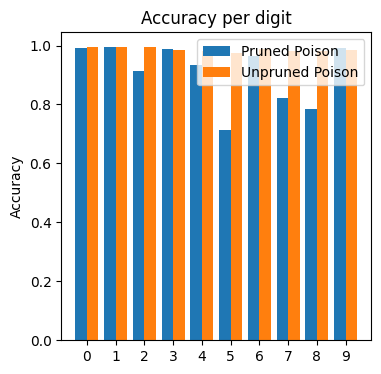

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

digits = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Bar width and x locations
w, x = 0.4, np.arange(len(digits))

fig, ax = plt.subplots(figsize=(4,4))
ax.bar(x - w/2, pruned_acc_digit, width=w, label='Pruned Poison')
ax.bar(x + w/2, unpruned_acc_digit, width=w, label='Unpruned Poison')

ax.set_xticks(x)
ax.set_xticklabels(digits)
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy per digit')
ax.legend()

plt.show()

### Test 0 Ends Here

In [1]:
# # THIS BLOCK USES MODEL CREATED DURING
# # checking the results of our model
# final_pruned_model = prune_SimpleSurrogate_FC_layers(surrogate_model, 0.3)
# # testset_data_transformed = testset.data.unsqueeze(1)
# # print(testset_data_transformed.size())

# for i in range(10):
#     testset_digit_i = testset.data[testset.targets == i]
#     testset_digit_i_labels = testset.targets[testset.targets == i]
#     testset_digit_i_transformed = testset_digit_i.unsqueeze(1).float().to(device)

#     predicted_labels_pruned = torch.argmax(final_pruned_model.forward(testset_digit_i_transformed), dim=1)
#     predicted_labels_unpruned = torch.argmax(surrogate_model.forward(testset_digit_i_transformed), dim=1)
#     accuracy_pruned = (predicted_labels_pruned == testset_digit_i_labels.to(device)).float().mean()
#     accuracy_unpruned = (predicted_labels_unpruned == testset_digit_i_labels.to(device)).float().mean()

#     print(f"The accuracy of pruned model on digit {i} is {accuracy_pruned}")
#     print(f"The accuracy of unpruned model on digit {i} is {accuracy_unpruned}")

### Test 1: Train a surrogate model on clean data and compare performance between pruned and unpruned models

In [ ]:
# train a new surrogate model with clean dataset
batch_size_clean = 40
n_epochs_clean = 10
clean_data_loader = DataLoader(non_poison_dataset, batch_size=40, shuffle=True)
clean_surrogate_model = SimpleSurrogateModel()
clean_surrogate_model.to(device)
clean_surrogate_optimizer = torch.optim.Adam(clean_surrogate_model.parameters(), lr=0.001)
clean_criterion = torch.nn.CrossEntropyLoss()

for epoch in range(n_epochs_clean):
    clean_loss_epoch = 0
    clean_accuracy_epoch = 0
    n_batches_clean = 0
    for batch_idx, (clean_data, clean_labels) in enumerate(clean_data_loader):
        n_batches_clean += 1
        clean_data, clean_labels = clean_data.to(device), clean_labels.to(device)
        clean_surrogate_optimizer.zero_grad()
        clean_outputs = clean_surrogate_model(clean_data)
        clean_loss = clean_criterion(clean_outputs, clean_labels)
        clean_loss.backward()
        clean_surrogate_optimizer.step()
        clean_loss_epoch += clean_loss.item()
        clean_predicted_labels = torch.argmax(clean_outputs, dim=1)
        clean_accuracy_epoch += (clean_predicted_labels == clean_labels).float().mean().item()

    final_clean_loss = clean_loss_epoch / n_batches_clean
    final_clean_accuracy = clean_accuracy_epoch / n_batches_clean
    print(f"The clean surrogate loss at epoch {epoch} is {final_clean_loss}")
    print(f"The clean surrogate accuracy at epoch {epoch} is {final_clean_accuracy}")


The clean surrogate loss at epoch 0 is 0.2547867943289109
The clean surrogate accuracy at epoch 0 is 0.9482648333439206
The clean surrogate loss at epoch 1 is 0.06663701731914097
The clean surrogate accuracy at epoch 1 is 0.9793351383784389
The clean surrogate loss at epoch 2 is 0.04983167426690496
The clean surrogate accuracy at epoch 2 is 0.9844339692769346
The clean surrogate loss at epoch 3 is 0.040618171485586226
The clean surrogate accuracy at epoch 3 is 0.987365235777878
The clean surrogate loss at epoch 4 is 0.036064312104092756
The clean surrogate accuracy at epoch 4 is 0.9890498711735091
The clean surrogate loss at epoch 5 is 0.031362165098228145
The clean surrogate accuracy at epoch 5 is 0.9903975796265744
The clean surrogate loss at epoch 6 is 0.028145693548587203
The clean surrogate accuracy at epoch 6 is 0.9915262861553871
The clean surrogate loss at epoch 7 is 0.023955893978894294
The clean surrogate accuracy at epoch 7 is 0.9926044524840589
The clean surrogate loss at e

In [ ]:
# comparing performance of pruned v/s unrpuned surrogate models
clean_pruned_model = prune_SimpleSurrogate_FC_layers(clean_surrogate_model, 0.3)
for i in range(10):
    testset_digit_i = testset.data[testset.targets == i]
    testset_digit_i_labels = testset.targets[testset.targets == i]
    testset_digit_i_transformed = testset_digit_i.unsqueeze(1).float().to(device)

    predicted_labels_pruned = torch.argmax(clean_pruned_model.forward(testset_digit_i_transformed), dim=1)
    predicted_labels_unpruned = torch.argmax(clean_surrogate_model.forward(testset_digit_i_transformed), dim=1)
    accuracy_pruned = (predicted_labels_pruned == testset_digit_i_labels.to(device)).float().mean()
    accuracy_unpruned = (predicted_labels_unpruned == testset_digit_i_labels.to(device)).float().mean()

    print(f"The accuracy of pruned model on digit {i} is {accuracy_pruned}")
    print(f"The accuracy of unpruned model on digit {i} is {accuracy_unpruned}")

The accuracy of pruned model on digit 0 is 0.9877550601959229
The accuracy of unpruned model on digit 0 is 0.9948979020118713
The accuracy of pruned model on digit 1 is 0.9022026658058167
The accuracy of unpruned model on digit 1 is 0.9964758157730103
The accuracy of pruned model on digit 2 is 0.42926356196403503
The accuracy of unpruned model on digit 2 is 0.9757751822471619
The accuracy of pruned model on digit 3 is 0.984158456325531
The accuracy of unpruned model on digit 3 is 0.9881188273429871
The accuracy of pruned model on digit 4 is 0.8360489010810852
The accuracy of unpruned model on digit 4 is 0.9857434034347534
The accuracy of pruned model on digit 5 is 0.3946188688278198
The accuracy of unpruned model on digit 5 is 0.9865471124649048
The accuracy of pruned model on digit 6 is 0.6513569951057434
The accuracy of unpruned model on digit 6 is 0.9853862524032593
The accuracy of pruned model on digit 7 is 0.957198441028595
The accuracy of unpruned model on digit 7 is 0.9815174937

### Test 1 Ends Here

### References:
- Datasets: https://docs.pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- U-Net: https://arxiv.org/pdf/1505.04597